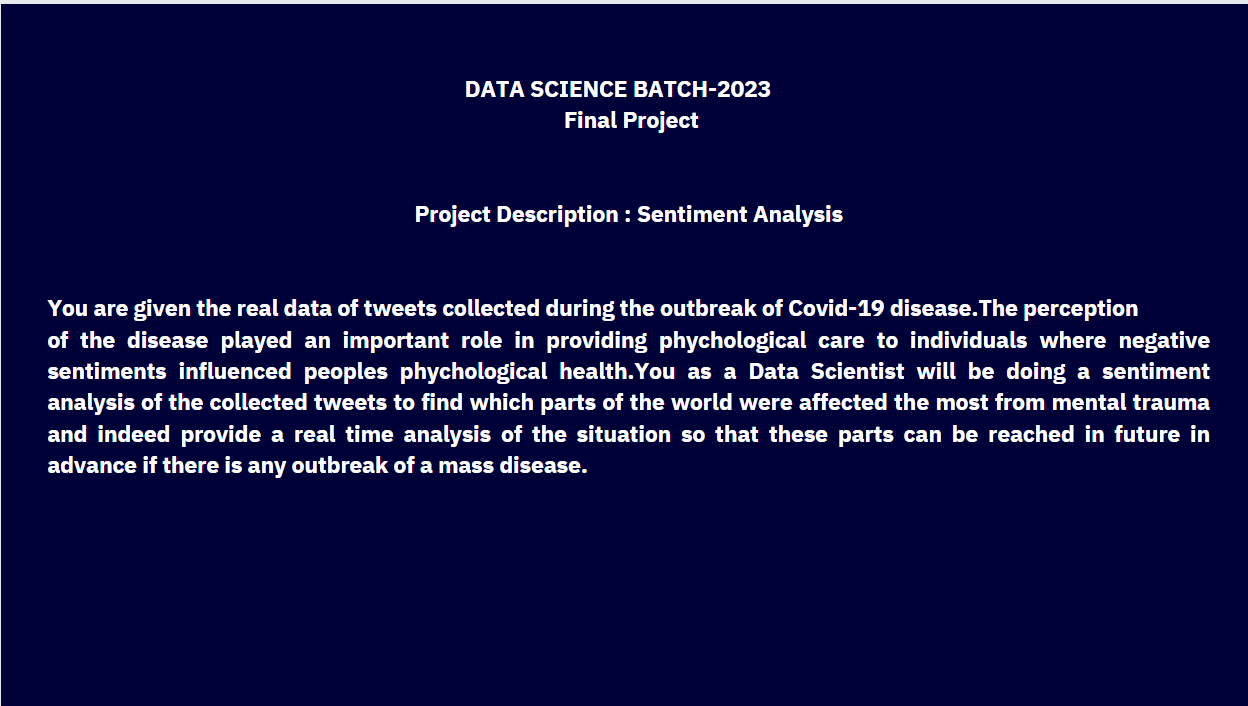

In [ ]:
#The pycountry library in Python provides functionalities for working with country-related data, including country information, code conversion, subdivision details, and searching/filtering capabilities.

!pip install pycountry
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 72.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=e0d1d14db3941cb21bae0305914f032d311ef6dc43f7d0f14619fc722ae6e6ac
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
#Initialize Thwe libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import warnings
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates
import re
import string
from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.regularizers import l2

np.random_seed = 0


warnings.filterwarnings('ignore')

In [ ]:
# Connect the Dataaset to the Dataframe
df = pd.read_excel('/content/Corona.xlsx')

In [ ]:
 #View the dataframe
 df.head(10)


UserName  ScreenName                   Location    TweetAt  \
0      3799       48751                     London 2020-03-16   
1      3800       48752                         UK 2020-03-16   
2      3801       48753                  Vagabonds 2020-03-16   
3      3802       48754                        NaN 2020-03-16   
4      3803       48755                        NaN 2020-03-16   
5      3804       48756  ÃœT: 36.319708,-82.363649 2020-03-16   
6      3805       48757       35.926541,-78.753267 2020-03-16   
7      3806       48758                    Austria 2020-03-16   
8      3807       48759            Atlanta, GA USA 2020-03-16   
9      3808       48760           BHAVNAGAR,GUJRAT 2020-03-16   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
5  As news of the regionÂ’s first confirmed COVID...            Positive  
6  Cashier at grocery store was sharing his insig...            Positive  
7  Was at the supermarket today. Didn't buy toile...             Neutral  
8  Due to COVID-19 our retail store and classroom...            Positive  
9  For corona prevention,we should stop to buy th...            Negative

## **EDA** and **Data Visualization**

In [ ]:
print("Total number of records in data: ",len(df))

Total number of records in data:  41157


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


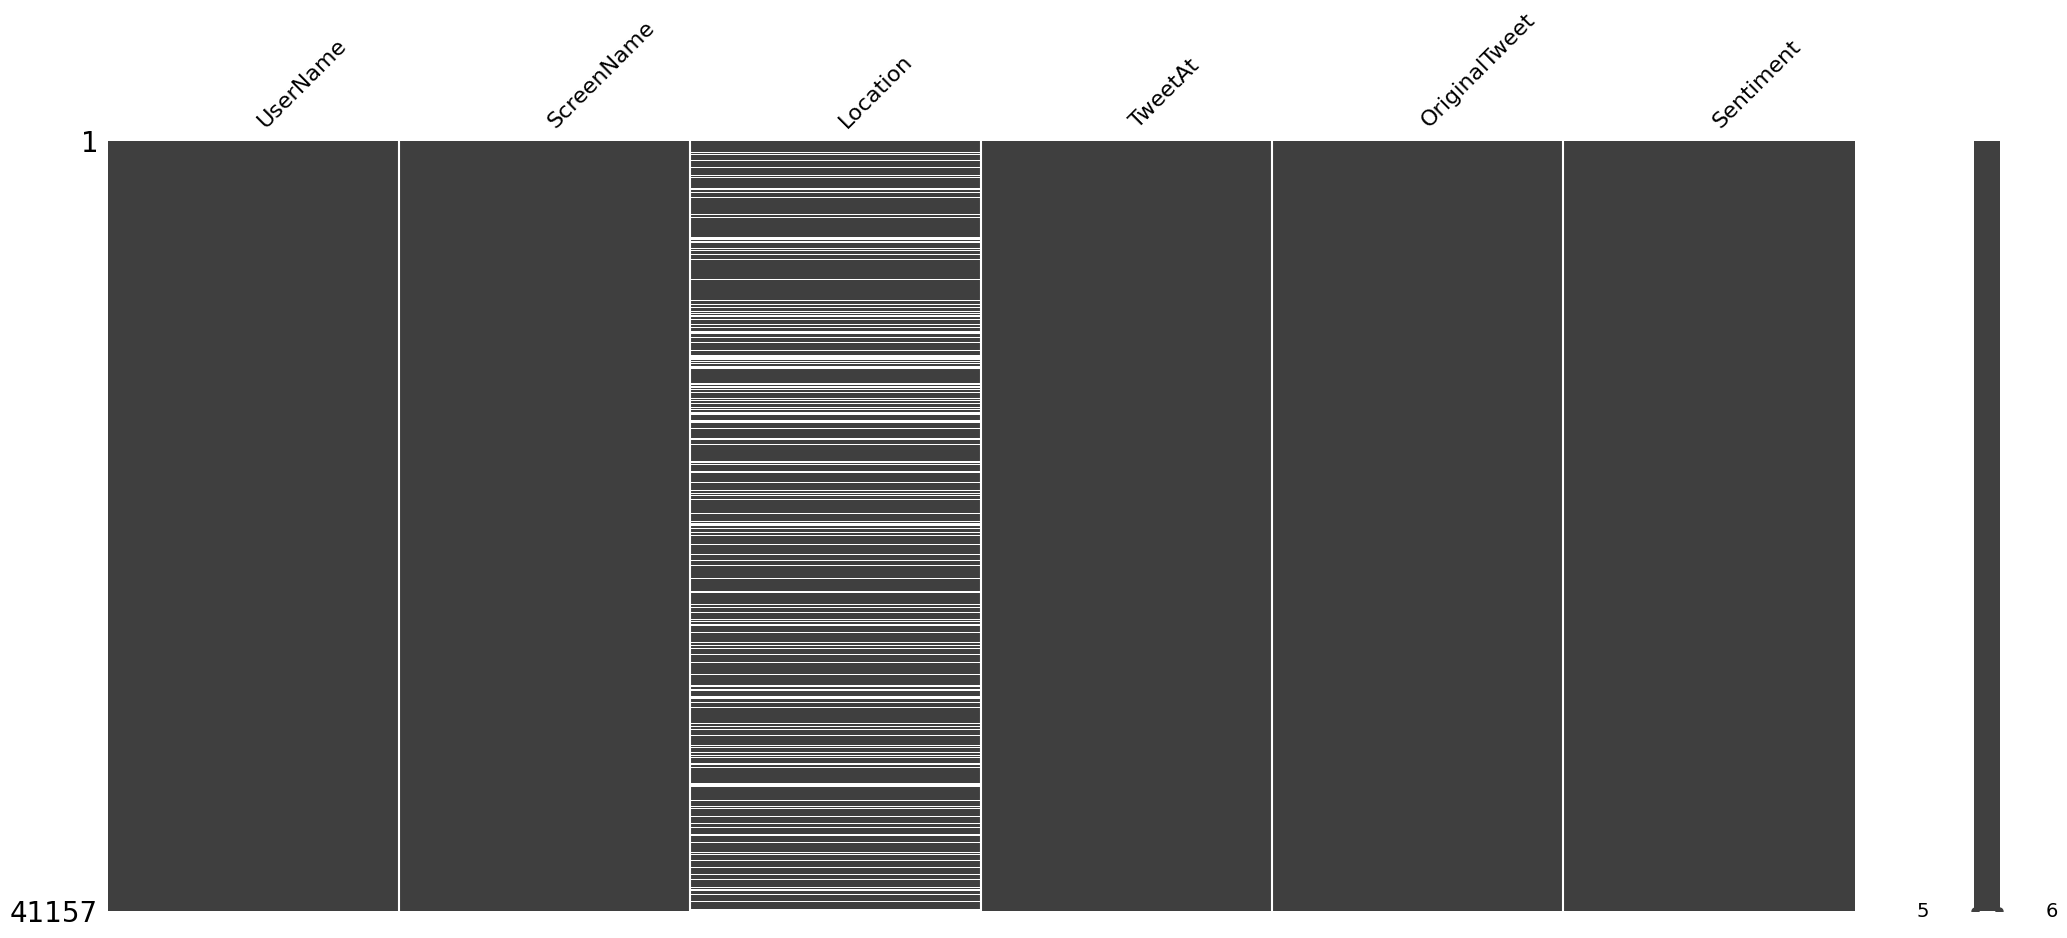

In [ ]:
#checking for missing values
import missingno as msno

msno.matrix(df);

In [ ]:
#Fill the blank space with Unknown to note loose the data
df['Location'].fillna('unknown', inplace=True)

In [ ]:
df['Location'].value_counts()

unknown                          8590
London                            540
United States                     528
London, England                   520
New York, NY                      395
                                 ... 
Views don't reflect employers       1
Charlotte, MI                       1
East Midlands, UK                   1
Mid Yell, Scotland                  1
i love you so much || he/him        1
Name: Location, Length: 12221, dtype: int64

In [ ]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

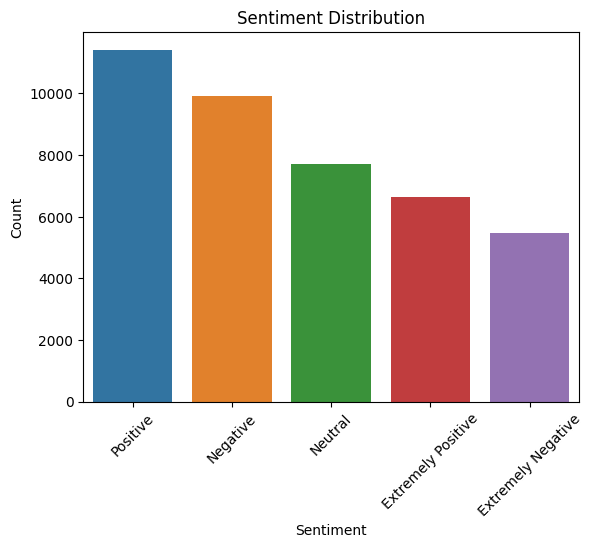

In [ ]:
# Plot the sentiment distribution

import seaborn as sns


# Calculate the value counts of 'Sentiment' column
sentiment_counts = df['Sentiment'].value_counts()

# Create the bar plot
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Set labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
# Clean the tweets remove unwanted urls special symbols and characters

import re

def clean_text(text):
    # Remove special characters, numbers, and coordinate positions
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = re.sub(r'\b\d+\.\d+\b', '', cleaned_text)
    cleaned_text = re.sub(r'\b\d+\b', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text = cleaned_text.strip()
    cleaned_text = cleaned_text.lower()
    return cleaned_text


df['OriginalTweet'] = df['OriginalTweet'].astype(str)
df['Location'] = df['Location'].astype(str)

# Clean the 'tweets' column
df['OriginalTweet'] = df['OriginalTweet'].apply(clean_text)

# Clean the 'countries' column
df['Location'] = df['Location'].apply(clean_text)

# Print the cleaned DataFrame









In [ ]:
c = list(pycountry.countries)

In [ ]:
# Filters out the correct location by text processes
def correct_location(x):
    for i in c:
        if str(i.name).lower() in x or str(i.alpha_2).lower() in x.split() or str(i.alpha_3).lower() in x.split():
            return str(i.name)
    return x

In [ ]:
df['Location'] = df['Location'].apply(lambda x: correct_location(x.lower()))

In [ ]:
df['Location'].unique()

array(['london', 'uk', 'Gabon', ..., 'north essex', 'pretoria gauteng',
       'les nyc'], dtype=object)

In [ ]:
df.head(15)

UserName  ScreenName         Location    TweetAt  \
0       3799       48751           london 2020-03-16   
1       3800       48752               uk 2020-03-16   
2       3801       48753            Gabon 2020-03-16   
3       3802       48754          unknown 2020-03-16   
4       3803       48755          unknown 2020-03-16   
5       3804       48756                t 2020-03-16   
6       3805       48757                  2020-03-16   
7       3806       48758          Austria 2020-03-16   
8       3807       48759            Gabon 2020-03-16   
9       3808       48760  bhavnagargujrat 2020-03-16   
10      3809       48761    makati manila 2020-03-16   
11      3810       48762           Canada 2020-03-16   
12      3811       48763       horningsea 2020-03-16   
13      3812       48764           Israel 2020-03-16   
14      3813       48765          unknown 2020-03-16   

                                        OriginalTweet           Sentiment  
0   menyrbie philgahan chrisitv httpstcoifzfanpa a...             Neutral  
1   advice talk to your neighbours family to excha...            Positive  
2   coronavirus australia woolworths to give elder...            Positive  
3   my food stock is not the only one which is emp...            Positive  
4   me ready to go at supermarket during the covid...  Extremely Negative  
5   as news of the regions first confirmed covid c...            Positive  
6   cashier at grocery store was sharing his insig...            Positive  
7   was at the supermarket today didnt buy toilet ...             Neutral  
8   due to covid our retail store and classroom in...            Positive  
9   for corona preventionwe should stop to buy thi...            Negative  
10  all month there hasnt been crowding in the sup...             Neutral  
11  due to the covid situation we have increased d...  Extremely Positive  
12  horningsea is a caring community lets all look...  Extremely Positive  
13  me i dont need to stock up on food ill just ha...            Positive  
14  adara releases covid resource center for trave...            Positive

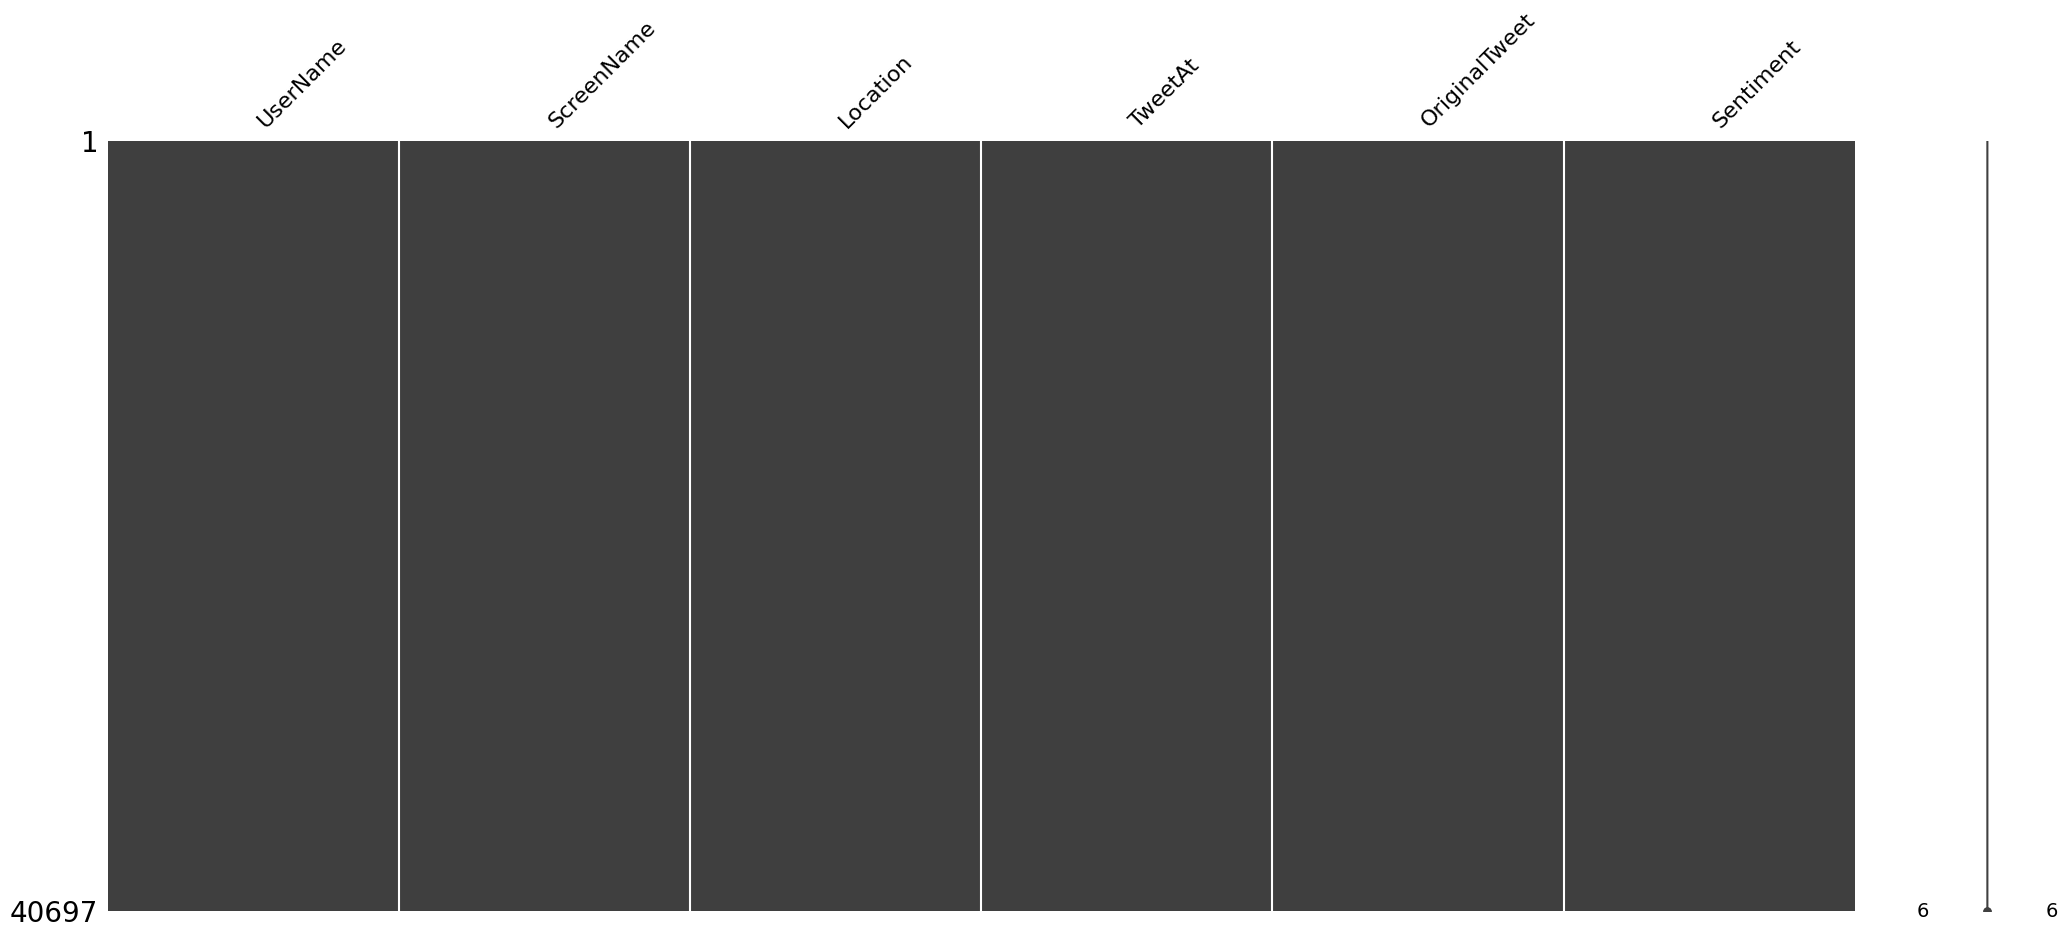

In [ ]:
 msno.matrix(df);

In [ ]:
#removes locations with just a single letter
df = df[df['Location'].apply(lambda x: len(str(x).strip()) > 1)]

In [ ]:
len(df)

40697

In [ ]:
df.head(10)

UserName  ScreenName         Location    TweetAt  \
0       3799       48751           london 2020-03-16   
1       3800       48752               uk 2020-03-16   
2       3801       48753            Gabon 2020-03-16   
3       3802       48754          unknown 2020-03-16   
4       3803       48755          unknown 2020-03-16   
7       3806       48758          Austria 2020-03-16   
8       3807       48759            Gabon 2020-03-16   
9       3808       48760  bhavnagargujrat 2020-03-16   
10      3809       48761    makati manila 2020-03-16   
11      3810       48762           Canada 2020-03-16   

                                        OriginalTweet           Sentiment  
0   menyrbie philgahan chrisitv httpstcoifzfanpa a...             Neutral  
1   advice talk to your neighbours family to excha...            Positive  
2   coronavirus australia woolworths to give elder...            Positive  
3   my food stock is not the only one which is emp...            Positive  
4   me ready to go at supermarket during the covid...  Extremely Negative  
7   was at the supermarket today didnt buy toilet ...             Neutral  
8   due to covid our retail store and classroom in...            Positive  
9   for corona preventionwe should stop to buy thi...            Negative  
10  all month there hasnt been crowding in the sup...             Neutral  
11  due to the covid situation we have increased d...  Extremely Positive

In [ ]:
#The purpose of the provided code is to generate a map visualization using the Folium library.
#The map shows the locations mentioned in the 'Location' column of the DataFrame
#and the corresponding count of tweets from each location. It geocodes the locations
#using the Nominatim geocoding service, adds markers to the map for each location,
#and displays the map. The resulting map can be saved as an HTML file.

import folium
from geopy.geocoders import Nominatim

# Prepare the data (location and tweet count)
locations = df['Location'].value_counts()

# Initialize the map
center_lat, center_lon = 0, 0  # initial center coordinates
zoom_level = 2  # initial zoom level
map_obj = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_level)

# Geocode the locations
geolocator = Nominatim(user_agent="tweet_map")
for location, count in locations.items():
    try:
        location_info = geolocator.geocode(location)
        if location_info is not None:
            lat, lon = location_info.latitude, location_info.longitude
            folium.Marker([lat, lon], popup=f'{location}: {count} tweets').add_to(map_obj) # add marker
    except Exception as e:
        print(f"Error geocoding location: {location}, Error: {e}")

# Display the map
map_obj.save('tweet_map.html')  # Saving the map as an HTML file
map_obj

Error geocoding location: bristol england, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=bristol+england&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: the great state of texas, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+great+state+of+texas&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: gulf area of southern u s, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=gulf+area+of+southern+u+s&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: treble d, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=treble+d&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: windsor south east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=windsor+south+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: stevenage east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=stevenage+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: wu lakoda, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=wu+lakoda&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: new york ny london uk, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=new+york+ny+london+uk&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: coast of lake mi, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=coast+of+lake+mi&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: halifax england, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=halifax+england&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: albany ny area, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=albany+ny+area&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: the commonwealth of virginia, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+commonwealth+of+virginia&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: rickmansworth east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=rickmansworth+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: motorway city of the s, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=motorway+city+of+the+s&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: wickford east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=wickford+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: perth wa kl, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=perth+wa+kl&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: west of everything, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=west+of+everything&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: on gadigal land, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=on+gadigal+land&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: wheathampstead east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=wheathampstead+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: whadjuk region wa, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=whadjuk+region+wa&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: washington the state, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=washington+the+state&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: california o, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=california+o&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: metropolitan city of turin, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=metropolitan+city+of+turin&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: union centre drive west c, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=union+centre+drive+west+c&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: isle of white, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=isle+of+white&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: we the north, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=we+the+north&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: northwest england, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=northwest+england&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: fema region v, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=fema+region+v&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: east ferris, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+ferris&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: the great south, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+great+south&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: hampton england, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=hampton+england&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: small town america, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=small+town+america&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: north west england san roque, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=north+west+england+san+roque&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: west central africa, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=west+central+africa&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: on cammeraygal land, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=on+cammeraygal+land&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: way north of los angeles, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=way+north+of+los+angeles&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: greater new york city area, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=greater+new+york+city+area&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: east vancouver, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+vancouver&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: ditton south east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=ditton+south+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: rayleigh east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=rayleigh+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: ct fl rd, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=ct+fl+rd&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: the t of pennsylvania, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+t+of+pennsylvania&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: greenway england, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=greenway+england&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: north county san diego, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=north+county+san+diego&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: london south west, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=london+south+west&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: bagshot south east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=bagshot+south+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: sheher england, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=sheher+england&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: south west florida, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=south+west+florida&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: south central pennsylvania, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=south+central+pennsylvania&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: woking south east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=woking+south+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: beaconsfield south east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=beaconsfield+south+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: great state of texas, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=great+state+of+texas&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: sheher n l, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=sheher+n+l&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: mount pleasant mi, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=mount+pleasant+mi&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: the land of enchantment, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+land+of+enchantment&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: california north of the wall, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=california+north+of+the+wall&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: hamburg metropolitan region, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=hamburg+metropolitan+region&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: west of reno east of omaha, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=west+of+reno+east+of+omaha&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: tanzania east africa, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=tanzania+east+africa&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: central san joaquin valley, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=central+san+joaquin+valley&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: land of the free, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=land+of+the+free&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: the state of resistance, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+state+of+resistance&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: ny state of mind, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=ny+state+of+mind&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: lightwater south east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=lightwater+south+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: loughton east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=loughton+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: chertsey south east, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=chertsey+south+east&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: ct on a, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=ct+on+a&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: southern calif, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=southern+calif&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error geocoding location: the capital of the world, Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+capital+of+the+world&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


In [ ]:
list(df['Location'].unique())

['london',
 'uk',
 'Gabon',
 'unknown',
 'Austria',
 'bhavnagargujrat',
 'makati manila',
 'Canada',
 'horningsea',
 'Israel',
 'houston texas',
 'Saudi Arabia',
 'north america',
 'Colombia',
 'southampton soxx xxx',
 'global',
 'downstage centre',
 'ketchum idaho',
 'United Arab Emirates',
 'new york ny',
 'United States',
 'markham ontario',
 'london england',
 'sverige',
 'fort worth texas',
 'houston',
 'vancouver british columbia',
 'midrand',
 'drogheda',
 'Macao',
 'washington dc',
 'ogden ut',
 'west midlands england',
 'reno nv',
 'san clemente',
 'spokane valley wa',
 'drifter',
 'hamilton ontario',
 'dallas tx',
 'boston',
 'the european union',
 'Iceland',
 'canvey island essex uk',
 'ncsu',
 'morgantown wv',
 'Belarus',
 'new york city',
 'cornwall england',
 'Morocco',
 'great wakering essex',
 'Australia',
 'barnsley england',
 'Thailand',
 'los angeles mostly',
 'houston tx',
 'kdh',
 'worcester massachusetts',
 'leicester england',
 'free goal setting guide',
 'planet

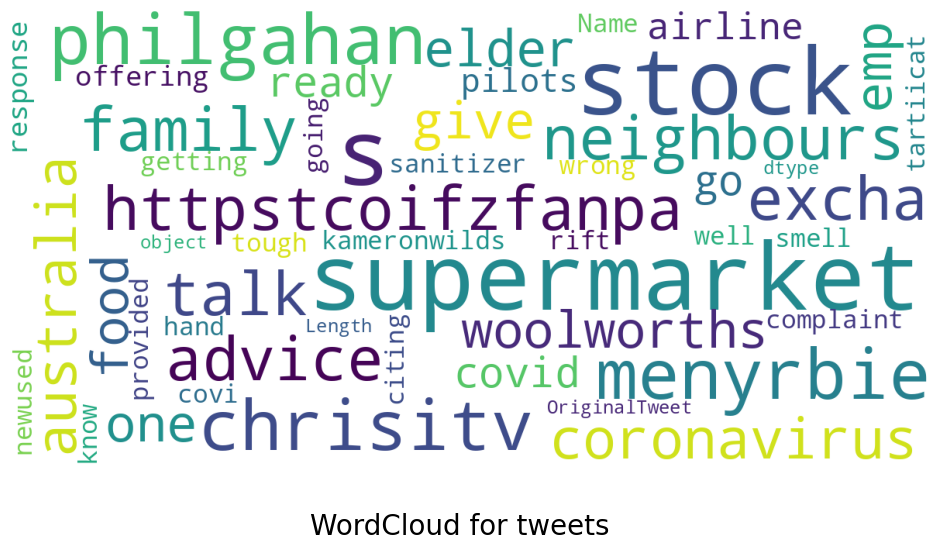

In [ ]:
#The purpose of this code is to generate a word cloud visualization of the text
#data in the 'OriginalTweet' column of the DataFrame df,
#providing a visual representation of the most frequently occurring words in the tweets.

stopwords_ = set(STOPWORDS) #Set of stopwords to exclude from the word cloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


show_wordcloud(df['OriginalTweet'], "WordCloud for tweets")

In [ ]:
#count the frequency of words in the 'OriginalTweet' column of a DataFrame, and
#then initialize a tokenizer object based on the collected word counts.

def word_counter(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

counter = word_counter(df['OriginalTweet'].append(df['OriginalTweet']))
num_of_words = len(counter)
max_len = 100

t = Tokenizer(num_words = num_of_words)
t.fit_on_texts(df['OriginalTweet'].append(df['OriginalTweet']))

In [ ]:
# Tweet count of top 20 Different countries

def plot_bar(x,y,title,x_label,y_label):
    fig = go.Figure(data=[go.Bar(
                x=x,
                y=y,
                text=y,
                textposition='auto',
            )])

    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label
    )

    fig.show()
plot_bar(df['Location'].value_counts().index[0:20],
         df['Location'].value_counts().values[0:20],
         "Top 20 Locations by the number of tweets",
         "Location",
         "Tweet Count")

In [ ]:
df.head(20)

UserName  ScreenName              Location    TweetAt  \
0       3799       48751                london 2020-03-16   
1       3800       48752                    uk 2020-03-16   
2       3801       48753                 Gabon 2020-03-16   
3       3802       48754               unknown 2020-03-16   
4       3803       48755               unknown 2020-03-16   
7       3806       48758               Austria 2020-03-16   
8       3807       48759                 Gabon 2020-03-16   
9       3808       48760       bhavnagargujrat 2020-03-16   
10      3809       48761         makati manila 2020-03-16   
11      3810       48762                Canada 2020-03-16   
12      3811       48763            horningsea 2020-03-16   
13      3812       48764                Israel 2020-03-16   
14      3813       48765               unknown 2020-03-16   
15      3814       48766         houston texas 2020-03-16   
16      3815       48767          Saudi Arabia 2020-03-16   
17      3816       48768                Canada 2020-03-16   
18      3817       48769         north america 2020-03-16   
19      3818       48770              Colombia 2020-03-16   
20      3819       48771  southampton soxx xxx 2020-03-16   
21      3820       48772                global 2020-03-16   

                                        OriginalTweet           Sentiment  
0   menyrbie philgahan chrisitv httpstcoifzfanpa a...             Neutral  
1   advice talk to your neighbours family to excha...            Positive  
2   coronavirus australia woolworths to give elder...            Positive  
3   my food stock is not the only one which is emp...            Positive  
4   me ready to go at supermarket during the covid...  Extremely Negative  
7   was at the supermarket today didnt buy toilet ...             Neutral  
8   due to covid our retail store and classroom in...            Positive  
9   for corona preventionwe should stop to buy thi...            Negative  
10  all month there hasnt been crowding in the sup...             Neutral  
11  due to the covid situation we have increased d...  Extremely Positive  
12  horningsea is a caring community lets all look...  Extremely Positive  
13  me i dont need to stock up on food ill just ha...            Positive  
14  adara releases covid resource center for trave...            Positive  
15  lines at the grocery store have been unpredict...            Positive  
16                      xdxd xdxd xdxd httpstcoblpvzh             Neutral  
17  eyeonthearctic mar russia consumer surveillanc...             Neutral  
18  amazon glitch stymies whole foods fresh grocer...  Extremely Positive  
19  for those who arent struggling please consider...            Positive  
20  with nations inficted with covid the world mus...  Extremely Negative  
21  httpstcoavkrrsyffxdxd xdxd the covid coronavir...             Neutral

# **Model Training** Activation relu and loss = sparse_categorical_crossentropy

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Train test split
train_x, test_x, train_y, test_y = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.1, random_state=30)

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)

train_tweets_sequences = tokenizer.texts_to_sequences(train_x)
test_tweets_sequences = tokenizer.texts_to_sequences(test_x)

vocab_size = len(tokenizer.word_index) + 1

max_length = 100  # maximum length of each sequence
train_tweets_padded = pad_sequences(train_tweets_sequences, maxlen=max_length, padding='post')
test_tweets_padded = pad_sequences(test_tweets_sequences, maxlen=max_length, padding='post')

# Sentiment labels Dictionary
sentiment_labels = {
    'Positive': 0,
    'Negative': 1,
    'Extremely Negative': 2,
    'Extremely Positive': 3,
    'Neutral': 4
}

train_labels = np.array([sentiment_labels[sentiment] for sentiment in train_y])
test_labels = np.array([sentiment_labels[sentiment] for sentiment in test_y])
# Model
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 100, input_length=max_length))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))  # 5 output for 5 sentiments

#Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Train
history = model.fit(train_tweets_padded, train_labels, epochs=5,
                    validation_data=(test_tweets_padded, test_labels), batch_size=40)

#Evaluation
loss, accuracy = model.evaluate(test_tweets_padded, test_labels)
print(f"Test accuracy: {accuracy}")

Epoch 1/5
916/916 [==============================] - 32s 34ms/step - loss: 1.3914 - accuracy: 0.3845 - val_loss: 1.1061 - val_accuracy: 0.5430
Epoch 2/5
916/916 [==============================] - 8s 8ms/step - loss: 0.8814 - accuracy: 0.6700 - val_loss: 0.8963 - val_accuracy: 0.6477
Epoch 3/5
916/916 [==============================] - 7s 8ms/step - loss: 0.5929 - accuracy: 0.8138 - val_loss: 0.9062 - val_accuracy: 0.6636
Epoch 4/5
916/916 [==============================] - 7s 8ms/step - loss: 0.4112 - accuracy: 0.8829 - val_loss: 0.8726 - val_accuracy: 0.7017
Epoch 5/5
128/128 [==============================] - 0s 2ms/step - loss: 0.9434 - accuracy: 0.6961
Test accuracy: 0.6960688233375549


# **Model Validation Activation relu and loss = sparse_categorical_crossentropy**

In [ ]:
#evaluate the performance of a model by calculating the loss and accuracy on the
#test data, make predictions on the test data, and calculate the F1 score as a
#measure of the model's overall performance. The F1 score is used to assess the
#balance between precision and recall in the classification results.

import numpy as np
from sklearn.metrics import f1_score

#model evaluation
loss, accuracy = model.evaluate(test_tweets_padded, test_labels)
print(f"Test accuracy: {accuracy}")

#predictions
predictions = model.predict(test_tweets_padded)
predicted_labels = np.argmax(predictions, axis=1)

#Calculate F1 score
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 score: {f1}")

128/128 [==============================] - 0s 3ms/step - loss: 0.9434 - accuracy: 0.6961
Test accuracy: 0.6960688233375549
128/128 [==============================] - 1s 4ms/step
F1 score: 0.6968332180993865


In [ ]:
#code to calculate the validation loss and Accuracy
validation_tweets_sequences = tokenizer.texts_to_sequences(test_x)
validation_tweets_padded = pad_sequences(validation_tweets_sequences, maxlen=max_length, padding='post')

validation_loss, validation_accuracy = model.evaluate(validation_tweets_padded, test_labels)
print(f"Validation loss: {validation_loss}")
print(f"Validation accuracy: {validation_accuracy}")

128/128 [==============================] - 0s 2ms/step - loss: 0.9434 - accuracy: 0.6961
Validation loss: 0.9433513283729553
Validation accuracy: 0.6960688233375549


In [ ]:
# Code to test the model on the test data to predict the sentiments

test_tweets_sequences = tokenizer.texts_to_sequences(test_x)
test_tweets_padded = pad_sequences(test_tweets_sequences, maxlen=max_length, padding='post')


predictions = model.predict(test_tweets_padded)
predicted_classes = np.argmax(predictions, axis=1)


sentiment_names = {v: k for k, v in sentiment_labels.items()}
predicted_sentiments = [sentiment_names[prediction] for prediction in predicted_classes]

# predicted sentiments
for tweet, sentiment in zip(test_x, predicted_sentiments):
    print(f"Tweet: {tweet}")
    print(f"Predicted Sentiment: {sentiment}")
    print()

Streaming output truncated to the last 5000 lines.
Predicted Sentiment: Negative

Tweet: lolol what its like working at a grocery store during covid httpstcoqcaomemfh
Predicted Sentiment: Positive

Tweet: were in this together huh us drugmaker doubled price on potential coronavirus treatment httpstcoqbqowpacga via ft
Predicted Sentiment: Neutral

Tweet: new house hold rule coronavirus toiletpaper bez httpstcodxwzuzhipx
Predicted Sentiment: Neutral

Tweet: hello darkness my old friend the supermarket is being cleaned out after gov koike tells residents to stay home this weekend
Predicted Sentiment: Positive

Tweet: a welcome respite something took place in a walmart toiletpaper aisle that had nothing to do with coronavirus covidusa grocery xdxd xdxd httpstcouzmbdrnde
Predicted Sentiment: Positive

Tweet: that big of a sacrifice think instead of the many heroes medical pros first responders grocery store clerks garbage collectors who treat the infected and keep society goingxdxd xdxd i l

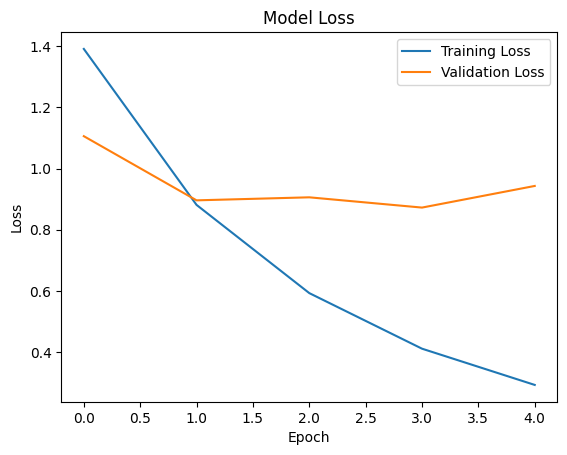

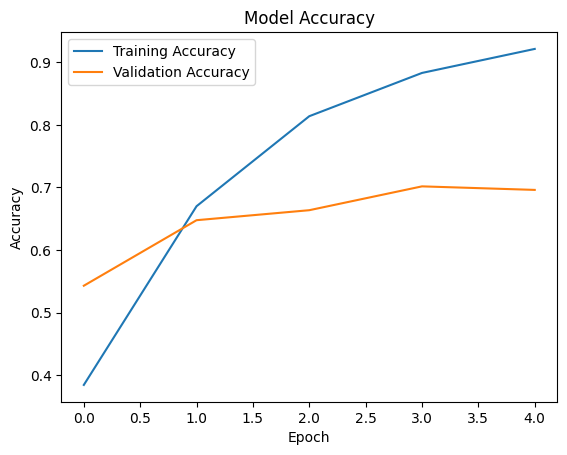

In [ ]:
#When the training loss and validation loss meet at the same point, it indicates
#that the model has reached a point of optimal generalization. In other words,
#the model has learned to perform well not only on the training data but also on unseen data represented by the validation dataset.

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#When the training accuracy and validation accuracy meet at the same point,
#it indicates that the model has reached a point of optimal generalization.
#This means that the model is performing equally well on both the training data and the validation data.
# Plott validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Using Random Sentences to test the model to predict the Sentiments

import random


#random sentences
random_sentences = [
    "I love the sunny weather today!",
    "This movie is absolutely terrible.",
    "The food at this restaurant is amazing.",
    "I'm feeling really sad and disappointed.",
    "The concert was fantastic, I had a great time!",
    "I can't believe how frustrating this situation is.",
    "The book I'm reading is so inspiring and uplifting.",
    "I'm so bored, there's nothing interesting to do.",
    "I'm excited about the upcoming trip, it's going to be awesome!",
    "I'm angry and frustrated with the poor customer service."
]

# Preprocess and predict sentiment for each sentence
for sentence in random_sentences:
    # Preprocess
    preprocessed_sentence = preprocess_text(sentence)

    # if the preprocessed sentence is empty then continue
    if not preprocessed_sentence:
        continue

    # text to sequences conversion
    sentence_sequence = tokenizer.texts_to_sequences([preprocessed_sentence])

    # Pad the sequence
    padded_sequence = pad_sequences(sentence_sequence, maxlen=max_length, padding='post')

    #model to predict sentiments
    predictions = model.predict(padded_sequence)
    predicted_classes = np.argmax(predictions, axis=1)

    sentiment_names = {v: k for k, v in sentiment_labels.items()}
    predicted_sentiments = [sentiment_names[prediction] for prediction in predicted_classes]

    # Print the predicted sentiments
    for tweet, sentiment in zip([sentence], predicted_sentiments):
        print(f"Tweet: {tweet}")
        print(f"Predicted Sentiment: {sentiment}")
        print()

1/1 [==============================] - 0s 20ms/step
Tweet: I love the sunny weather today!
Predicted Sentiment: Positive

1/1 [==============================] - 0s 19ms/step
Tweet: This movie is absolutely terrible.
Predicted Sentiment: Negative

1/1 [==============================] - 0s 17ms/step
Tweet: The food at this restaurant is amazing.
Predicted Sentiment: Positive

1/1 [==============================] - 0s 17ms/step
Tweet: I'm feeling really sad and disappointed.
Predicted Sentiment: Extremely Negative

1/1 [==============================] - 0s 19ms/step
Tweet: The concert was fantastic, I had a great time!
Predicted Sentiment: Extremely Positive

1/1 [==============================] - 0s 22ms/step
Tweet: I can't believe how frustrating this situation is.
Predicted Sentiment: Negative

1/1 [==============================] - 0s 21ms/step
Tweet: The book I'm reading is so inspiring and uplifting.
Predicted Sentiment: Positive

1/1 [==============================] - 0s 21ms/step


# **Model Training with Activation sigmoid and loss = Means squared error**

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Train test split
train_x, test_x, train_y, test_y = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.1, random_state=30)

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)

train_tweets_sequences = tokenizer.texts_to_sequences(train_x)
test_tweets_sequences = tokenizer.texts_to_sequences(test_x)

vocab_size = len(tokenizer.word_index) + 1

max_length = 100  # maximum length of each sequence
train_tweets_padded = pad_sequences(train_tweets_sequences, maxlen=max_length, padding='post')
test_tweets_padded = pad_sequences(test_tweets_sequences, maxlen=max_length, padding='post')

# Sentiment labels Dictionary
sentiment_labels = {
    'Positive': 0,
    'Negative': 1,
    'Extremely Negative': 2,
    'Extremely Positive': 3,
    'Neutral': 4
}

train_labels = np.array([sentiment_labels[sentiment] for sentiment in train_y])
test_labels = np.array([sentiment_labels[sentiment] for sentiment in test_y])
# Model
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 100, input_length=max_length))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(64, activation='sigmoid'))
model.add(keras.layers.Dense(5, activation='softmax'))  # 5 output for 5 sentiments

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
#Train
history = model.fit(train_tweets_padded, train_labels, epochs=5,
                    validation_data=(test_tweets_padded, test_labels), batch_size=40)

#Evaluation
loss, accuracy = model.evaluate(test_tweets_padded, test_labels)
print(f"Test accuracy: {accuracy}")

Epoch 1/5
916/916 [==============================] - 33s 35ms/step - loss: 4.5762 - accuracy: 0.1208 - val_loss: 4.4364 - val_accuracy: 0.1405
Epoch 2/5
916/916 [==============================] - 9s 10ms/step - loss: 4.5761 - accuracy: 0.1591 - val_loss: 4.4364 - val_accuracy: 0.1791
Epoch 3/5
916/916 [==============================] - 9s 10ms/step - loss: 4.5761 - accuracy: 0.1804 - val_loss: 4.4364 - val_accuracy: 0.1590
Epoch 4/5
916/916 [==============================] - 11s 12ms/step - loss: 4.5761 - accuracy: 0.1909 - val_loss: 4.4364 - val_accuracy: 0.2174
Epoch 5/5
128/128 [==============================] - 1s 4ms/step - loss: 4.4364 - accuracy: 0.1735
Test accuracy: 0.17346437275409698


# **Model Validation** **with Activation sigmoid  and loss = Means squared error**

In [ ]:
#evaluate the performance of a model by calculating the loss and accuracy on the
#test data, make predictions on the test data, and calculate the F1 score as a
#measure of the model's overall performance. The F1 score is used to assess the
#balance between precision and recall in the classification results.

import numpy as np
from sklearn.metrics import f1_score

#model evaluation
loss, accuracy = model.evaluate(test_tweets_padded, test_labels)
print(f"Test accuracy: {accuracy}")

#predictions
predictions = model.predict(test_tweets_padded)
predicted_labels = np.argmax(predictions, axis=1)

#Calculate F1 score
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 score: {f1}")

128/128 [==============================] - 0s 3ms/step - loss: 4.4364 - accuracy: 0.1735
Test accuracy: 0.17346437275409698
128/128 [==============================] - 0s 2ms/step
F1 score: 0.1457291972607584


In [ ]:
#code to calculate the validation loss and Accuracy
validation_tweets_sequences = tokenizer.texts_to_sequences(test_x)
validation_tweets_padded = pad_sequences(validation_tweets_sequences, maxlen=max_length, padding='post')

validation_loss, validation_accuracy = model.evaluate(validation_tweets_padded, test_labels)
print(f"Validation loss: {validation_loss}")
print(f"Validation accuracy: {validation_accuracy}")

128/128 [==============================] - 0s 2ms/step - loss: 4.4364 - accuracy: 0.1735
Validation loss: 4.436415195465088
Validation accuracy: 0.17346437275409698


In [ ]:
# Code to test the model on the test data to predict the sentiments

test_tweets_sequences = tokenizer.texts_to_sequences(test_x)
test_tweets_padded = pad_sequences(test_tweets_sequences, maxlen=max_length, padding='post')


predictions = model.predict(test_tweets_padded)
predicted_classes = np.argmax(predictions, axis=1)


sentiment_names = {v: k for k, v in sentiment_labels.items()}
predicted_sentiments = [sentiment_names[prediction] for prediction in predicted_classes]

# predicted sentiments
for tweet, sentiment in zip(test_x, predicted_sentiments):
    print(f"Tweet: {tweet}")
    print(f"Predicted Sentiment: {sentiment}")
    print()

Streaming output truncated to the last 5000 lines.
Predicted Sentiment: Positive

Tweet: lolol what its like working at a grocery store during covid httpstcoqcaomemfh
Predicted Sentiment: Extremely Positive

Tweet: were in this together huh us drugmaker doubled price on potential coronavirus treatment httpstcoqbqowpacga via ft
Predicted Sentiment: Extremely Positive

Tweet: new house hold rule coronavirus toiletpaper bez httpstcodxwzuzhipx
Predicted Sentiment: Extremely Negative

Tweet: hello darkness my old friend the supermarket is being cleaned out after gov koike tells residents to stay home this weekend
Predicted Sentiment: Extremely Negative

Tweet: a welcome respite something took place in a walmart toiletpaper aisle that had nothing to do with coronavirus covidusa grocery xdxd xdxd httpstcouzmbdrnde
Predicted Sentiment: Extremely Positive

Tweet: that big of a sacrifice think instead of the many heroes medical pros first responders grocery store clerks garbage collectors who tr

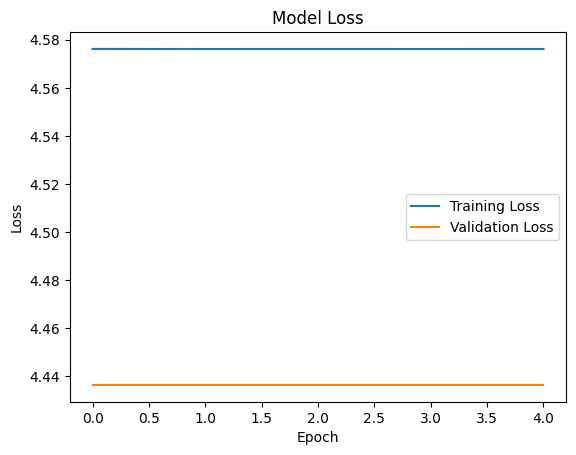

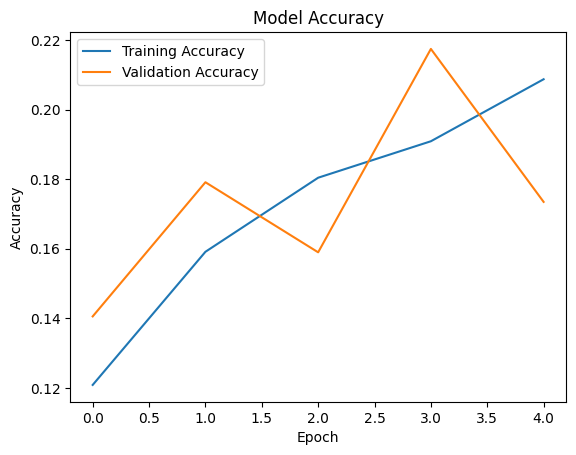

In [ ]:
#When the training loss and validation loss meet at the same point, it indicates
#that the model has reached a point of optimal generalization. In other words,
#the model has learned to perform well not only on the training data but also on unseen data represented by the validation dataset.

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#When the training accuracy and validation accuracy meet at the same point,
#it indicates that the model has reached a point of optimal generalization.
#This means that the model is performing equally well on both the training data and the validation data.
# Plott validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Using Random Sentences to test the model to predict the Sentiments

import random


#random sentences
random_sentences = [
    "I love the sunny weather today!",
    "This movie is absolutely terrible.",
    "The food at this restaurant is amazing.",
    "I'm feeling really sad and disappointed.",
    "The concert was fantastic, I had a great time!",
    "I can't believe how frustrating this situation is.",
    "The book I'm reading is so inspiring and uplifting.",
    "I'm so bored, there's nothing interesting to do.",
    "I'm excited about the upcoming trip, it's going to be awesome!",
    "I'm angry and frustrated with the poor customer service."
]

# Preprocess and predict sentiment for each sentence
for sentence in random_sentences:
    # Preprocess
    preprocessed_sentence = preprocess_text(sentence)

    # if the preprocessed sentence is empty then continue
    if not preprocessed_sentence:
        continue

    # text to sequences conversion
    sentence_sequence = tokenizer.texts_to_sequences([preprocessed_sentence])

    # Pad the sequence
    padded_sequence = pad_sequences(sentence_sequence, maxlen=max_length, padding='post')

    #model to predict sentiments
    predictions = model.predict(padded_sequence)
    predicted_classes = np.argmax(predictions, axis=1)

    sentiment_names = {v: k for k, v in sentiment_labels.items()}
    predicted_sentiments = [sentiment_names[prediction] for prediction in predicted_classes]

    # Print the predicted sentiments
    for tweet, sentiment in zip([sentence], predicted_sentiments):
        print(f"Tweet: {tweet}")
        print(f"Predicted Sentiment: {sentiment}")
        print()

1/1 [==============================] - 0s 18ms/step
Tweet: I love the sunny weather today!
Predicted Sentiment: Extremely Positive

1/1 [==============================] - 0s 18ms/step
Tweet: This movie is absolutely terrible.
Predicted Sentiment: Extremely Positive

1/1 [==============================] - 0s 18ms/step
Tweet: The food at this restaurant is amazing.
Predicted Sentiment: Extremely Positive

1/1 [==============================] - 0s 22ms/step
Tweet: I'm feeling really sad and disappointed.
Predicted Sentiment: Extremely Positive

1/1 [==============================] - 0s 23ms/step
Tweet: The concert was fantastic, I had a great time!
Predicted Sentiment: Extremely Positive

1/1 [==============================] - 0s 19ms/step
Tweet: I can't believe how frustrating this situation is.
Predicted Sentiment: Extremely Positive

1/1 [==============================] - 0s 33ms/step
Tweet: The book I'm reading is so inspiring and uplifting.
Predicted Sentiment: Extremely Positive

1/

In [ ]:
#function defined for preprocess text

import re

def preprocess_text(text):

    text = text.lower()

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()

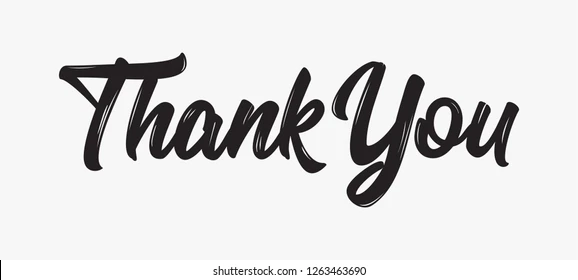